In [1]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import numpy as np

In [2]:
import os
import pandas as pd
#os.getcwd()
df = pd.read_csv("../data/wyflows_w_response_and_geo.csv")
df.head()

,homeMSOA,workMSOA,workhome,metro,train,bus,taxi,motorcycle,car,cycle,...,otherqual,centheat,nrooms,wzclass,distance,response,disttrainstn,distcoachstn,distbusstop,distmway
0,E02002183,E02002184,0.0,0.0,0.01506,0.069277,0.0,0.0,0.743976,0.012048,...,0.028852,0.980225,5.9,4,2.684270,0.144439,0.437264,7.354263,0.021183,22.434402
1,E02002183,E02002185,0.0,0.0,0.12500,0.000000,0.0,0.0,0.812500,0.000000,...,0.028852,0.980225,5.9,6,7.265346,0.058454,0.270787,7.354263,0.031054,18.741927
2,E02002183,E02002186,0.0,0.0,0.00000,0.011628,0.0,0.0,0.941860,0.011628,...,0.028852,0.980225,5.9,6,4.906847,0.229892,1.636134,5.263695,0.483769,23.216051
3,E02002183,E02002187,0.0,0.0,0.00000,0.000000,0.0,0.0,0.916667,0.000000,...,0.028852,0.980225,5.9,4,6.938770,0.166186,0.935954,6.985427,0.328198,18.379430
4,E02002183,E02002188,0.0,0.0,0.00000,0.100000,0.0,0.0,0.700000,0.000000,...,0.028852,0.980225,5.9,5,4.595884,-0.002455,2.604336,3.576567,0.699492,19.114812


In [3]:
df.columns

Index(['homeMSOA', 'workMSOA', 'workhome', 'metro', 'train', 'bus', 'taxi',
       'motorcycle', 'car', 'cycle', 'walk', 'othertransp', 'npeople', '16-24',
       '25-34', '35-49', '50-54', '65-74', '75+', 'female', 'house0carpct',
       'house1carpct', 'house2carpct', 'house3carpct', 'house4carpct',
       'ppperhect', 'econactivpct', 'econinactivpct', 'vghealth', 'ghealth',
       'fhealth', 'bhealth', 'vbhealth', 'white', 'mixed', 'asian', 'black',
       'otherethn', 'noqual', 'aptshpqual', 'lev1qual', 'lev2qual', 'lev3qual',
       'lev4qual', 'otherqual', 'centheat', 'nrooms', 'wzclass', 'distance',
       'response', 'disttrainstn', 'distcoachstn', 'distbusstop', 'distmway'],
      dtype='object')

In [4]:
Xfull = df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).values
Yfull = df['car'].values

predictors = list(df.drop(['homeMSOA','workMSOA','car','response','npeople','workhome','metro','train','bus','taxi','motorcycle','cycle','walk','othertransp'], axis=1).columns)

In [5]:
# DO NOT USE THE FULL DATASET, SPLIT OFF A TRAINING SET BEFORE GOING FURTHER, AND NEVER USE THE FULL SET

import math

idx = list(range(Xfull.shape[0]))
np.random.seed(seed=5)
np.random.shuffle(idx)
np.random.seed(seed=None)

trainsetsize = math.floor(Xfull.shape[0]/2)
trainidx = idx[:trainsetsize]

X, Y = Xfull[trainidx,:], Yfull[trainidx]

In [6]:
predictors

['16-24',
 '25-34',
 '35-49',
 '50-54',
 '65-74',
 '75+',
 'female',
 'house0carpct',
 'house1carpct',
 'house2carpct',
 'house3carpct',
 'house4carpct',
 'ppperhect',
 'econactivpct',
 'econinactivpct',
 'vghealth',
 'ghealth',
 'fhealth',
 'bhealth',
 'vbhealth',
 'white',
 'mixed',
 'asian',
 'black',
 'otherethn',
 'noqual',
 'aptshpqual',
 'lev1qual',
 'lev2qual',
 'lev3qual',
 'lev4qual',
 'otherqual',
 'centheat',
 'nrooms',
 'wzclass',
 'distance',
 'disttrainstn',
 'distcoachstn',
 'distbusstop',
 'distmway']

In [7]:
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

#cross_valsets = StratifiedKFold(n_splits=2)
cross_valsets = KFold(n_splits=10)
for train_index, test_index in cross_valsets.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xval = X[train_index], X[test_index]
    Ytrain, Yval = Y[train_index], Y[test_index]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xval = scaler.transform(Xval)

# We use X = X_train + X_test for the cross-validation runs, so scale X too (note: X is already a training set)
X = scaler.transform(X)

In [9]:
#import pickle

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/Homesite_Quote_conversion_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    

    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_train.pkl', 'rb') as fb:
#    Xtrain = pickle.load(fb)

#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/X_standard_val.pkl', 'rb') as fb:
#    Xtest = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Ytrain.pkl', 'rb') as fb:
#    Ytrain = pickle.load(fb)
    
#with open('/home/ilan/Desktop/BNP_Paribas_Cardif_Kaggle/Yval.pkl', 'rb') as fb:
#    Ytest = pickle.load(fb)
    
 
    
#X = np.concatenate((Xtrain, Xtest), axis=0)
#Y = np.concatenate((Ytrain, Ytest), axis=0)

Split the data set into training, validation, and test sets.  
We will not touch the test set at all.

def TrainValTestSplit(X, Y, fracs_list=[0.7, 0.2, 0.1], shuffle=True, seed=42):
    """Split the samples x features Numpy array, X, into training, validation, and test sets as
    specified in fractions in list fracs_list (e.g. [0.6, 0.2, 0.2])
    
    Return Numpy arrays:
    Xtrain, Ytrain, Xval, Yval, Xtest, Ytest"""
    
    assert X.shape[0] == Y.shape[0]
    
    assert sum(fracs_list) == 1.0
    
    trainfrac, valfrac, testfrac = fracs_list
    idxs = np.arange(X.shape[0])

    if shuffle==True:
        np.random.seed(seed)
        np.random.shuffle(idxs)
        np.random.seed(None) # Reset to the default value in case numpy uses the seed later (somewhere below)

    trainidx = idxs[:int(trainfrac*len(idxs))]
    validx = idxs[int(trainfrac*len(idxs)):int(trainfrac*len(idxs))+int(valfrac*len(idxs))]
    testidx = idxs[int(trainfrac*len(idxs))+int(valfrac*len(idxs)):]

    #Xtrain, Ytrain = X[trainidx], Y[trainidx]
    #Xval, Yval = X[validx], Y[validx]
    #Xtest, Ytest = X[testidx], Y[testidx]
    #return Xtrain, Ytrain, Xval, Yval, Xtest, Ytest
    return trainidx,validx,testidx

trainidx, validx, testidx = TrainValTestSplit(X, Y, fracs_list=[0.6, 0.2, 0.2])

Xtrain, Ytrain = X[trainidx], Y[trainidx]
Xval, Yval = X[validx], Y[validx]
#Xtest, Ytest = X[testidx], Y[testidx]

The size of the training and validation sets, as well as the class labels and their distribution.

In [10]:
print(Xtrain.shape)
print(Xval.shape)

(24213, 40)
(2690, 40)


Choose scaling. Standard scaling, minmax scaling, whitening, etc.

In [11]:
# Perform data whitening (make covariance matrix the identity matrix to remove auto-correlations)
def whitening(X):
    Xcentred = X - np.mean(X, axis=0)
    cov = np.dot(Xcentred.T, Xcentred) / float(Xcentred.shape[0])
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(Xcentred,U)
    # Xrot_reduced = np.dot(Xcentred, U[:,:100])
    Xwhite = Xrot / np.sqrt(S + 1e-5)
    return Xwhite

Check for missing values. Impute if values are missing.

In [12]:
def fancyImpute(X_incomplete):
    """Imputation methods. Options: SimpleFill, DenseKNN, SoftImpute,
    IterativeSVD, MICE (ordinal variables only), MatrixFactorization,
    NuclearNormMinimization (too slow for large matrices)."""
    
    import fancyimpute as fi
    #from fancyimpute import (NuclearNormMinimization, BiScaler, DenseKNN)

    # rescale both rows and columns to have zero mean and unit variance
    biscaler = fi.BiScaler()
    X_incomplete_normalized = biscaler.fit_transform(X_incomplete)

    # use 3 nearest rows which have a feature to fill in each row's missing features
    #solver = fi.DenseKNN(k=3)
    solver = fi.SoftImpute()
    # Options for solver = NuclearNormMinimization
    X_filled_normalized = solver.complete(X_incomplete_normalized)
    X_filled = biscaler.inverse_transform(X_filled_normalized)

    #mse = ((X_filled[missing_mask] - X[missing_mask]) ** 2).mean()
    #print("MSE of reconstruction: %f" % mse)
    return X_filled

In [13]:
print(float(Xtrain[np.isnan(Xtrain)].shape[0])/Xtrain.shape[0])
print(float(Xval[np.isnan(Xval)].shape[0])/Xval.shape[0])

0.0
0.0


In [14]:
if Xtrain.any() == np.nan:
    Xtrain = fancyImpute(Xtrain)
if Xval.any() == np.nan:
    Xval = fancyImpute(Xval)

In [15]:
Ytrain = Ytrain.reshape((Ytrain.shape[0], 1))
print(Ytrain.shape)
Yval = Yval.reshape((Yval.shape[0], 1))
print(Yval.shape)

(24213, 1)
(2690, 1)


Build the Multi-Layer Perceptron

In [16]:
import theano
from theano import tensor as T
#from theano.printing import debugprint

#theano.config.compute_test_value = 'warn' # default is 'off'
theano.config.compute_test_value = 'off'
#print theano.config.optimizer # default value is 'fast_run'
#print theano.config.exception_verbosity # default value is 'low'

import LasagneUpdateRules_Feb_2017 as lur

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [17]:
print(theano.__version__) # T.nnet.relu() activation function available only from Theano 0.7.1 onwards

0.9.0beta1.dev-3343d912717ee85c5c2e0572cfae94581b35e32b


In [18]:
def floatX(array):
    """Convert array to Numpy array of a type supported by the CPU or GPU, accordingly"""
    return np.asarray(array, dtype=theano.config.floatX)

def init_weights(shape, frac=0.01):
    """Initialize weights randomly. Reduce weight size by factor to keep them closer to zero where gradient is largest
    and the learning is fastest at the beginning.
    This is Glorot initialisation, with a scaling factor."""
    #return theano.shared(floatX(frac*np.random.uniform(low=0.0, high=1.0, size=shape), borrow=True)
    #return theano.shared(floatX(np.sqrt(2/(shape[0]*shape[1]))*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)
    return theano.shared(floatX(np.sqrt(2)*np.random.normal(loc=0, scale=1, size=shape)), borrow=True)

def init_bias(shape):
    """Initialize bias to array of zeros"""
    return theano.shared(value=np.zeros(shape, dtype=theano.config.floatX), borrow=True)

def init_ortho(shape):
    """Initialize weights to an orthogonal matrix. Output matrix is square,
    output matrix will only be of the requested dimensions if square"""
    #W = np.random.randn(*shape)
    W = np.random.normal(loc=0, scale=1, size=shape)
    u, s, v = np.linalg.svd(W)
    #return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    #return theano.shared(value=np.sqrt(2/(shape[0]*shape[1])).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)
    return theano.shared(value=np.sqrt(2).astype(theano.config.floatX)*u.astype(theano.config.floatX), borrow=True)


#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
#from theano.sandbox.cuda.rng_curand import CURAND_RandomStreams as RandomStreams

def dropout(state_before, p=0.5):
    """Retain a fraction p of weights and set the other 1-p to zero"""
    #trng = T.shared_randomstreams.RandomStreams(np.random.randint(1000000, size=1))
    #trng = RandomStreams()
    trng = T.shared_randomstreams.RandomStreams()
    proj = T.cast((state_before * trng.binomial(state_before.shape, p=p, n=1, dtype=state_before.dtype))/p, theano.config.floatX)
    return proj

def to_onehot(array_column, n_classes=None):
    """Converts column array of integer labels (starting from 0) into
    one-hot encoding"""
    #array_column = np.asarray(array_column).flatten()
    if not np.equal(np.mod(array_column.any(), 1), 0):
        print("Problem: labels are not integers")
    if n_classes == None:
        # If no. of classes not given, deduce from data.
        # Can fail if not all possible classes found in vector.
        n_classes = len(np.unique(array_column))
    onehotcol = np.zeros((array_column.shape[0], n_classes))
    xmin = array_column.min()
    if np.equal(np.mod(array_column.all(), 1), 0) and xmin!=0:
        print("Labels don't start from 0, shifted them")
        array_column_shifted = array_column-xmin
        #print(array_column_shifted)
        for i in range(array_column_shifted.shape[0]):
            #print(i, array_column_shifted[i])
            onehotcol[i, int(array_column_shifted[i])] = 1
    else:
        for i in range(array_column.shape[0]):
            onehotcol[i, int(array_column[i])] = 1
    return onehotcol

import pickle, os

def save_model(parameters, filename):
    """Serialise Theano shared variables to disk"""
    dirname = 'saved_model'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(os.path.join(dirname, filename+'.pkl'), 'wb') as fb:
        for p in parameters:
            pickle.dump(p.get_value(borrow=True),fb, -1)

Convert to 1-of-N representation for N > 2 class classification.

In [19]:
#Ytrain = to_onehot(Ytrain)

Convert to GPU-friendly single precision floats

In [20]:
Xtrain = floatX(Xtrain)
Ytrain = floatX(Ytrain)

Xval = floatX(Xval)
Yval = floatX(Yval)

Convert data to theano shared variable type to make optimal usage of GPU memory.

In [21]:
Xtraintheano = theano.shared(Xtrain, borrow=True)
Ytraintheano = theano.shared(Ytrain, borrow=True)

Find greatest common divisor between training and validation sets, to use as batchsize to ensure prediction on full validation set. If this is not important, override batch size manually below.

In [22]:
from math import gcd

batchsize = gcd(Xtrain.shape[0], Xval.shape[0])

print(batchsize)

1


In [23]:
batchsize = 128

In [24]:
nfeats = Xtrain.shape[1]
widhidlay = nfeats # To ensure autoencoder input and output have the same dimensions, as they must.

Build and train the Stacked Denoising Auto-encoders for unsupervised pre-training of the lower (non-output) layers of the neural network.

In [25]:
n_epochs_pretrain = 100
n_pretrain_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)

In [26]:
X = T.matrix(name='X')
Y = T.matrix(name='Y')
index = T.lscalar()

def pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre):
    X = dropout(X, p=0.5)
    h1 = T.nnet.sigmoid(T.dot(X,w_h1_pre) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre.T) + b_h2_pre)
    return h2

In [27]:
w_h1_pre = init_weights((nfeats, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))

Xpred = pretrain_model(X, w_h1_pre, b_h1_pre, b_h2_pre)


L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) #+ 0.001*L1 + 0.001*L2
#cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.01)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain1 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain1(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output1 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano1 = theano.shared(floatX(ae_output1), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [28]:
print(ae_outputtheano1.get_value())

[[ -2.32635593e+00  -9.50652659e-01   4.47010174e-02 ...,  -1.38667807e-01
    1.85808763e-01  -5.17859720e-02]
 [  7.75005102e+00   5.16786635e-01  -5.47307730e-01 ...,  -2.05138296e-01
   -1.04537591e-01  -5.23345992e-02]
 [ -2.52789044e+00  -1.42049086e+00  -7.43601546e-02 ...,  -5.31671802e-03
   -1.54213890e-01   6.42710149e-01]
 ..., 
 [ -8.88678208e-02  -1.57653876e-02   7.29265690e-01 ...,  -8.05199802e-01
   -2.13273391e-02   4.17980045e-01]
 [  9.05441269e-02  -9.99894023e-01   6.96894109e-01 ...,  -5.45989370e+00
    2.39019934e-02  -1.57952309e+00]
 [ -8.68406370e-02  -1.36894941e+00  -1.33908555e-01 ...,  -2.94424385e-01
    1.03929102e-01  -3.97942811e-01]]


In [29]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights) + b_h1_pre)
    h1 = dropout(h1, p=0.5)
    h2 = T.nnet.sigmoid(T.dot(h1,w_h1_pre) + b_h2_pre)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre.T) + b_h3_pre)
    return h3

Xpred = pretrain_model(X, ae_outputtheano1, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre)

L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) #+ 0.001*L1 + 0.001*L2
#cost = T.mean(T.sqr(Xpred-X))

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.01)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain2 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain2(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output2 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano2 = theano.shared(floatX(ae_output2), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [30]:
print(ae_outputtheano2.get_value())

[[  0.20239402  -0.19285268  -0.80508977 ..., -10.27325726  -2.1361258
   -1.37374747]
 [ -0.45245641   0.18777901   0.05764891 ...,  -3.00755262  -0.09142762
   -0.54726589]
 [-19.24469757  -0.07363039   0.37303171 ...,   1.54923129  -0.23637392
   -0.14820921]
 ..., 
 [ -0.84397352  -0.94770455  -0.45031282 ...,  -0.5962882   -0.48407543
   -1.34779239]
 [  0.06986652  -0.20666374   1.22184551 ...,  -1.73674464  -0.44442856
   -6.81022644]
 [ -0.16104195  -1.57446694   0.13233574 ...,  -0.21707682  -0.18352818
    0.31077555]]


In [31]:
w_h1_pre = init_ortho((widhidlay, widhidlay))
b_h1_pre = init_bias((batchsize, widhidlay))
b_h2_pre = init_bias((batchsize, widhidlay))
b_h3_pre = init_bias((batchsize, widhidlay))
b_h4_pre = init_bias((batchsize, widhidlay))


def pretrain_model(X, previous_weights1, previous_weights2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre):
    h1 = T.nnet.sigmoid(T.dot(X,previous_weights1) + b_h1_pre)
    h2 = T.nnet.sigmoid(T.dot(h1,previous_weights2) + b_h2_pre)
    h2 = dropout(h2, p=0.5)
    h3 = T.nnet.sigmoid(T.dot(h2,w_h1_pre) + b_h3_pre)
    h4 = T.nnet.sigmoid(T.dot(h3,w_h1_pre.T) + b_h4_pre)
    return h4

Xpred = pretrain_model(X, ae_outputtheano1, ae_outputtheano2, w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre)

L1 = T.sum(T.abs_(w_h1_pre))
L2 = T.sum(T.sqr(w_h1_pre))

cost = T.mean(T.sqr(Xpred-X)) #+ 0.001*L1 + 0.001*L2

params = [w_h1_pre, b_h1_pre, b_h2_pre, b_h3_pre, b_h4_pre]

#updates = sgd(cost,params,lr=0.01)
#updates = lur.sgd(cost,params,learning_rate=0.01)
#updates = lur.adagrad(cost, params, learning_rate=0.001)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.01)
#updates = lur.adamax(cost,params,learning_rate=0.005)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.001)
#cost = -T.mean(T.log(yprobs)*Y)

pretrain3 = theano.function(
        inputs=[index],
        outputs=(Xpred,w_h1_pre),
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


for epoch in range(n_epochs_pretrain):
    #print("Computing epoch {0} of {1}".format(epoch+1,n_epochs))
    for batchidx in range(n_pretrain_batches):
        firsthidlay_weights = pretrain3(batchidx)[1]
    if epoch == n_epochs_pretrain-1:
        ae_output3 = firsthidlay_weights
    #print(firsthidlay_weights[0])

ae_outputtheano3 = theano.shared(floatX(ae_output3), borrow=True)
#ae_outputtheano1 = theano.shared(floatX(firsthidlay_weights), borrow=True)

In [32]:
print(ae_outputtheano3.get_value())

[[  0.07127632   0.50816733  -0.1544057  ...,   0.40684357   0.12157594
  -14.4142437 ]
 [ -5.97602844  -1.07428706   1.12373877 ...,   3.51851678   2.86282349
   -1.06136286]
 [  0.1390214   -8.44774342 -13.19944096 ...,  -0.62626725  -0.82545531
    0.26210824]
 ..., 
 [  4.11810541 -20.51300621  -8.53683376 ...,  -3.91026545  -0.16650578
   -0.19320154]
 [  0.09775146  -0.26706454  -2.2201438  ...,  -0.67720497  -0.39735353
    0.34576094]
 [  2.29450202   0.2634345    0.05759998 ...,  -1.54899728  -0.84804535
    1.66307998]]


Build the neural network itself.

In [ ]:
#X = T.matrix(name='X')
#Y = T.matrix(name='Y')
#index = T.lscalar()

dropout_p = 0.5
relu_alpha = 0.

def model_train(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    #o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    o = T.dot(h3,w_o) + b_o
    return o

def model_test(X,w_h1,b_h1,w_h2,b_h2,w_h3,b_h3,w_o,b_o):
    h1 = T.nnet.relu(T.dot(X,w_h1) + b_h1, alpha=relu_alpha)
    #h1 = T.nnet.sigmoid(T.dot(X,w_h1) + b_h1)
    #h1 = dropout(h1, p=dropout_p)
    h2 = T.nnet.relu(T.dot(h1,w_h2) + b_h2, alpha=relu_alpha)
    #h2 = T.nnet.sigmoid(T.dot(h1,w_h2) + b_h2)
    #h2 = dropout(h2, p=dropout_p)
    h3 = T.nnet.relu(T.dot(h2,w_h3) + b_h3, alpha=relu_alpha)
    #h3 = T.nnet.sigmoid(T.dot(h2,w_h3) + b_h3)
    #h3 = dropout(h3, p=dropout_p)
    #o = T.nnet.softmax(T.dot(h3,w_o) + b_o)
    #o = T.nnet.sigmoid(T.dot(h3,w_o) + b_o)
    o = T.dot(h3,w_o) + b_o
    return o


nfeats = Xtrain.shape[1]
widhidlay = nfeats
nclasses = 1
#nclasses = len(np.unique(Ytrain))  # Use 1 for binary classification or regression

# 3 hidden layers, initialise the weights and biases
#w_h1 = init_weights((nfeats, widhidlay))
w_h1 = ae_outputtheano1
b_h1 = init_bias((batchsize, widhidlay))
#w_h2 = init_ortho((widhidlay, widhidlay))
w_h2 = ae_outputtheano2
b_h2 = init_bias((batchsize, widhidlay))
#w_h3 = init_ortho((widhidlay, widhidlay))
w_h3 = ae_outputtheano3
b_h3 = init_bias((batchsize, widhidlay))
w_o = init_weights((widhidlay, nclasses))
b_o = init_bias((batchsize, nclasses))

# Runs the NN and outputs the result from its output node
#yprobs_train = model_train(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
#yprobs_test = model_test(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
ypred_train = model_train(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)
ypred_test = model_test(X, w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o)


# Predicted label is 1 if its probability is >=0.5, and 0 otherwise.
#ypred = (yprobs >= 0.5)


#ypred_train = T.argmax(yprobs_train)
#ypred_test = T.argmax(yprobs_test)

#ypred_train = T.switch(T.lt(yprobs_train, 0.5), 0, 1)
#ypred_test = T.switch(T.lt(yprobs_test, 0.5), 0, 1)

#ypred_train = T.switch(T.lt(yprobs_train, 0.07), 0, 1)
#ypred_test = T.switch(T.lt(yprobs_test, 0.07), 0, 1)

#err = T.mean(T.neq(ypred, Y))

params = [w_h1, b_h1, w_h2, b_h2, w_h3, b_h3, w_o, b_o]


#L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) 
#L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) 

L1 = T.sum(T.abs_(w_h2)) + T.sum(T.abs_(w_h3)) + T.sum(T.abs_(w_h1)) + T.sum(T.abs_(w_o))
L2 = T.sum(T.sqr(w_h2)) + T.sum(T.sqr(w_h3)) + T.sum(T.sqr(w_h1)) + T.sum(T.sqr(w_o))

    
#cost = T.mean(T.nnet.categorical_crossentropy(yprobs_train, Y)) + 0.01*L1 + 0.01*L2
#cost = T.mean(T.nnet.binary_crossentropy(yprobs_train, Y)) + 0.001*L1 + 0.001*L2
#cost = -(Y*T.log(yprobs_train) + (1-Y)*T.log(1-yprobs_train)).mean() + 0.001*L1 + 0.001*L2
#cost = T.mean(T.nnet.binary_crossentropy(yprobs, Y)) + 0.01*L2
cost = T.mean(T.sqr(ypred_train-Y)) #+ 0.01*L1 + 0.01*L2
#cost = T.mean(T.sqr(yprobs_train-Y))

#updates = lur.sgd(cost,params,learning_rate=0.001)
#updates = lur.adagrad(cost, params, learning_rate=0.01)
#updates = lur.adadelta(cost,params,learning_rate=0.01)
updates = lur.adam(cost,params,learning_rate=0.01)
#updates = lur.adamax(cost,params,learning_rate=0.01)
#updates = lur.rmsprop(cost,params,learning_rate=0.001)
#updates = lur.nesterov_momentum(cost,params,learning_rate=0.01)




train = theano.function(
        inputs=[index],
        outputs=cost,
        #outputs=(cost,yprobs,err),
        updates=updates,
        allow_input_downcast=True,
        givens={
            X: Xtraintheano[index * batchsize : (index + 1) * batchsize],
            Y: Ytraintheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Xvaltheano = theano.shared(Xval, borrow=True)
Yvaltheano = theano.shared(Yval, borrow=True)

predict = theano.function(
        inputs=[index],
        #outputs=yprobs,
        #outputs=(yprobs,ypred),
        #outputs=(cost,yprobs,err),
        outputs=ypred_test,
        #outputs=(yprobs_test,ypred_test),
        allow_input_downcast=True,
        givens={
            X: Xvaltheano[index * batchsize : (index + 1) * batchsize]
        }
    )


Train the neural network.

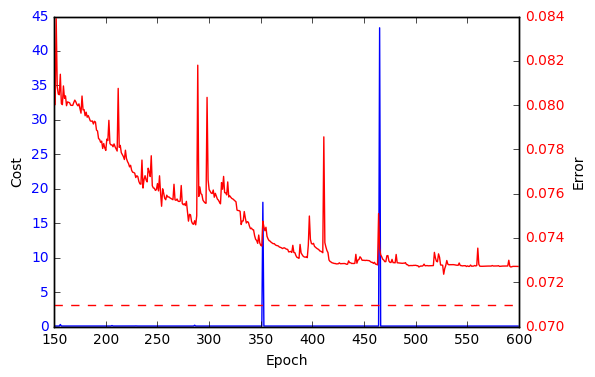

In [ ]:
import time
from scipy.stats import mode

n_train_batches = int(Xtraintheano.get_value(borrow=True).shape[0] / batchsize)
n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

n_epochs = 1000

plt.ion()

start = time.time()
epochs = []
costs = []
errors = []
#randomerror = 1 - 1.0/len(np.unique(Yval))
#randomerror = np.mean()
#mostcommonerror = np.mean(Yval != mode(Yval)[0][0]) #error from always predicting most common class
for epoch in range(n_epochs):
    epochstart = time.time()
    ypreds = np.empty((batchsize*n_test_batches, 1), dtype=float)
    #yprobs = np.empty((batchsize*n_test_batches, 1), dtype=float)
    for batchidx in range(n_train_batches):
        batchcost = train(batchidx)
        if batchcost == np.nan:
            print("NaN cost. Exiting. Try lowering the learning rate.")
            break
    for batchidx in range(n_test_batches):
        #batchyprob, batchypred = predict(batchidx)
        batchypred = predict(batchidx)
        #yprobs[batchsize*batchidx:batchsize*(batchidx+1)] = batchyprob
        ypreds[batchsize*batchidx:batchsize*(batchidx+1)] = batchypred
    #print("Epoch: {0}, runtime: {1}, cost: {2}".format(epoch, time.time()-epochstart, batchcost))
    epochs.append(epoch)
    costs.append(batchcost)
    
    epochYtest = Yval[:ypreds.shape[0]]
    #if epochYtest.shape[1]>1: #If Yval is in one-hot form change back to single int to compare with ypred
    #    epochYtest = np.argmax(epochYtest, axis=1)
    
    epochErr = np.mean((epochYtest - ypreds)**2)
    #epochAcc = np.mean(epochYtest == ypreds)
    #epochErr = np.mean(epochYtest != ypreds)
    
    errors.append(epochErr)
    
    randomerror = np.mean((epochYtest - np.mean(Yval))**2)
    
    #if epochErr < randomerror and epochErr < mostcommonerror:
    #    save_model(params, 'model-epoch_'+str(epoch))
    if (epoch+1)%(n_epochs/10)==0:
        # If error drops precipitously at the beginning the y-scale of the plots is large and ruins plots
        # remove first epochs to avoid this
        epochsplot = epochs[150:]
        costsplot = costs[150:]
        errorsplot = errors[150:]
        fig, ax = plt.subplots()
        ax.plot(epochsplot,costsplot, 'b-')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Cost")
        for tl in ax.get_yticklabels():
            tl.set_color('b')

        ax1 = ax.twinx()
        ax1.plot(epochsplot, errorsplot, 'r-')
        ax1.set_ylabel("Error")
        ax1.axhline(randomerror, color='r', linestyle='dashed')
        #ax1.axhline(mostcommonerror, color='r', linestyle='dotted')
        for tl in ax1.get_yticklabels():
            tl.set_color('r')    

        epochtime = time.time()-epochstart
        print("Epoch runtime: {0:.3g}s".format(epochtime), end="\r")

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
#    if len(errors) >= 40: # Run at least for 40 epochs
#        temperrs = np.asarray(errors)
#        if epochErr >= temperrs[-30] - temperrs[-30:].std():
#            break # If error hasn't improved by 1 SD in 30 epochs, stop
    
    #print("Epoch: {0}\tAccuracy: {1:.4g}\tError: {2:.3g}\tCost: {3:.6g}\tRuntime: {4:.3g}".format(epoch, epochAcc, epochErr, batchcost, epochtime))

end = time.time()

print("Training took {0:.3g} seconds.".format(end-start))

Inspect output: predicted probabilities and final weight matrices.

In [35]:
#print(yprobs[:100])

In [36]:
w_h1.get_value()

array([[-1.16370356, -3.98086786, -1.98386347, ..., -0.5157361 ,
        -0.54091287,  0.11813538],
       [ 3.33419657, -0.04839806, -2.04159522, ..., -3.0195787 ,
         0.46194857, -0.69820392],
       [-4.07596397, -2.72196841, -0.70420104, ..., -2.61074209,
         0.78090554,  0.12692203],
       ..., 
       [ 0.38967064,  2.05850053,  0.44588459, ..., -1.32389522,
        -1.79329705, -0.98731303],
       [-0.81393236,  0.50369245, -0.57153141, ..., -5.82378006,
         1.74907911, -3.99408174],
       [-1.00369275,  0.93589145,  0.4778291 , ..., -0.53635001,
        -0.11899801, -4.41823578]], dtype=float32)

In [37]:
w_h2.get_value()

array([[ -1.51878476,  -0.91261703,  -1.96008146, ..., -10.50990105,
         -3.14269519,  -1.60460389],
       [ -2.85292697,  -0.93355691,  -2.38712955, ...,  -3.50388861,
         -2.75200105,  -0.6018731 ],
       [-19.04048347,  -1.00767517,  -1.42935383, ...,  -0.33378032,
         -1.16619968,  -0.73847443],
       ..., 
       [ -4.35225964,  -2.49608421,  -2.67564964, ...,  -1.12343395,
         -2.30342722,  -1.38561189],
       [ -3.05263925,  -0.86479616,  -0.2090368 , ...,  -1.85978687,
         -0.73839927,  -6.79955149],
       [ -2.70977736,  -2.39477587,  -1.26831174, ...,  -0.56545234,
         -2.02744412,  -0.36778873]], dtype=float32)

In [38]:
w_h3.get_value()

array([[ -3.14625233e-01,  -1.69071585e-01,  -2.89094061e-01, ...,
         -9.95607749e-02,  -2.26649597e-01,  -1.41182232e+01],
       [ -6.01114464e+00,  -1.39945102e+00,  -1.89159930e-01, ...,
          1.04200554e+00,   1.59485567e+00,  -1.49226081e+00],
       [ -4.95660067e-01,  -7.69555044e+00,  -1.10553761e+01, ...,
         -2.84150302e-01,  -5.42025924e-01,  -8.34790468e-01],
       ..., 
       [  3.16117406e+00,  -1.98365154e+01,  -9.61777306e+00, ...,
         -6.00148726e+00,  -2.15854093e-01,  -5.69307566e-01],
       [ -5.25342882e-01,  -5.04171550e-01,  -2.00503421e+00, ...,
         -4.76541340e-01,  -1.88369125e-01,   4.91034687e-02],
       [  2.29792142e+00,  -6.06503904e-01,  -5.75307012e-01, ...,
         -1.71857607e+00,  -1.04735899e+00,   1.97401140e-02]], dtype=float32)

In [39]:
w_o.get_value()

array([[ -1.11938155e+00],
       [ -4.11969870e-01],
       [ -1.05107687e-01],
       [ -6.17304087e-01],
       [ -8.87203932e-01],
       [ -1.11714692e-03],
       [  1.19324252e-01],
       [ -1.01136707e-01],
       [  5.42461991e-01],
       [  5.86019933e-01],
       [ -7.23948002e-01],
       [  1.12025686e-01],
       [  5.19929588e-01],
       [ -5.60998857e-01],
       [ -7.41516531e-01],
       [ -7.78545082e-01],
       [ -4.71046893e-03],
       [ -3.17572534e-01],
       [ -8.34929705e-01],
       [ -1.08599886e-01],
       [ -5.69290638e-01],
       [  1.69950247e-01],
       [  2.38008544e-01],
       [  3.24593723e-01],
       [  1.00301411e-02],
       [ -8.64978433e-01],
       [  4.08147991e-01],
       [  8.01246703e-01],
       [  6.58710659e-01],
       [  2.47755185e-01],
       [  5.45977056e-01],
       [ -5.88298380e-01],
       [ -8.58817846e-02],
       [  6.14628434e-01],
       [ -3.37409049e-01],
       [ -6.17715940e-02],
       [ -1.57738656e-01],
 

Analyse the final performance.

In [40]:
errors = np.asarray(errors)
print("Minimum error at epoch {0}: {1:.3g} (Accuracy: {2:.4g})".format(errors.argmin(), errors[errors.argmin()], 1-errors[errors.argmin()]))

Minimum error at epoch 963: 0.0727 (Accuracy: 0.9273)


n_test_batches = int(Xvaltheano.get_value(borrow=True).shape[0] / batchsize)

results = np.empty((batchsize*n_test_batches, 1),dtype=int)
#resultprobs = np.empty((batchsize*n_test_batches, 1),dtype=float)
for batchidx in range(n_test_batches):
    #resultprobs[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[0]
    #results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[1]
    results[batchsize*batchidx:batchsize*(batchidx+1)] = predict(batchidx)[0]
    
results = np.asarray(results, dtype=int)
results = results.flatten()


#Yval_testing = Yval_testing.reshape(Yval_testing.shape[0],)

Yval_testing = Yval[:results.shape[0]]
Xval_testing = Xval[:results.shape[0]]

#if Yval_testing.shape[1] > 0:
#    Yval_testing = np.argmax(Yval_testing, axis=1
Yval_testing = Yval_testing.flatten()
Yval_testing = np.asarray(Yval_testing, dtype=int)

#np.unique(ypreds)
yprobs[1:10]

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(Yval_testing, yprobs[:Yval_testing.shape[0]], pos_label=1)
roc_auc = roc_auc_score(Yval_testing, yprobs[:Yval_testing.shape[0]])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]


thresholds[np.where(fpr == find_nearest(fpr,0.5))]
#fpr

NN_accuracy = np.mean(Yval_testing == results)

print("Accuracy: {0:.2g}".format(NN_accuracy))
print("\n(Accuracy of random guesses: {0:.2g})".format(1.0/len(np.unique(epochYtest))))
print("\n(Accuracy of predicting dominant class for all: {0:.2g})".format(np.mean(Yval == mode(Yval)[0][0])))

print(results[:30])
print(Yval_testing[:30])

plt.figure(1)
plt.subplot(211)
plt.hist(results)
plt.subplot(212)
plt.hist(Yval_testing)
plt.show()

from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, target_names):
    ncls = len(set(y_true))
    cm = confusion_matrix(y_true, y_pred)

    
    # Normalise each row to its total (i.e. normalise by the number of samples in each class)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(12,12))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    #plt.cm.Blues
    #res = ax.imshow(np.array(cm_normalised), cmap=plt.cm.jet, 
    #                interpolation='nearest')
    res = ax.pcolor(np.array(cm_normalised))


    height = cm.shape[0]
    width = cm.shape[1]

    for x in range(ncls):
        for y in range(ncls):
            ax.annotate(str(cm[x][y]), xy=(y+0.5, x+0.5), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=20,color='w')

    cb = fig.colorbar(res,fraction=0.046, pad=0.04)

    #plt.imshow(cm_normalised, cmap='jet')
    
    plt.xticks(np.arange(ncls)+0.5, target_names, fontsize=16,rotation='vertical')
    plt.yticks(np.arange(ncls)+0.5, target_names, fontsize=16)
    #plt.tight_layout()
    plt.xlabel("Predicted label", fontsize=20)
    plt.ylabel("True label", fontsize=20)
    plt.title("Confusion matrix", fontsize=22)
    fig=plt.figure()

    return fig

#target_names = ['Setosa', 'Versicolour','Virginica']
#target_names = [str(i) for i in np.unique(np.concatenate((Ytrain, Yval_testing), axis=0))]

target_names = ["0","1"]

print(confusion_matrix(Yval_testing, results))
plot_confusion_matrix(Yval_testing, results, target_names=target_names)
plt.show()

from sklearn.metrics import classification_report

print(classification_report(Yval_testing, results, target_names=target_names))

Benchmark agains other similar classifiers, possibly one simple and similar one as a baseline, and one usually performant one (e.g. XGBoost) as a benchmark.

# Concatenate training and validation sets and undo one-hot encoding for sklearn classifiers to run CV
Xsklearn = np.concatenate((Xtrain,Xval), axis=0)

if Ytrain.shape[1] > 0:
    Ysklearn = np.concatenate((np.argmax(Ytrain, axis=1), Yval.flatten()),axis=0)
else:
    np.concatenate((Ytrain,Yval), axis=0)

from sklearn.cross_validation import cross_val_score

from sklearn import linear_model
clf = linear_model.Perceptron()

score = cross_val_score(clf, Xsklearn, Ysklearn, cv=10)

print(score)
print(score.mean())

from sklearn import linear_model
#clf = linear_model.ElasticNet()
clf = linear_model.LogisticRegression(penalty='l2', n_jobs=4)

score = cross_val_score(clf, Xsklearn, Ysklearn, cv=10)

print(score)
print(score.mean())

# If you have XGBoost installed you can benchmark against it as well:

# For description of XGBoost algorithm see:
#  http://xgboost.readthedocs.io/en/latest/model.html

from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
#clf = XGBClassifier()
score = cross_val_score(clf, Xsklearn, Ysklearn, cv=10)

print(score)
print(score.mean())

# Just by predicting zero everywhere we would get this fraction right
Yval_testing[Yval_testing==0].shape[0]/float(Yval_testing.shape[0])

Apply a shallow (desired for interpretability, see later) decision tree to the data, as a benchmark.

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)

score = cross_val_score(clf, Xsklearn, Ysklearn, cv=3)

print(score)
print(score.mean())

clf = tree.DecisionTreeClassifier(max_depth=2)
clf_data_to_target = clf.fit(Xsklearn, Ysklearn)
tree.export_graphviz(clf_data_to_target, out_file='tree.dot')

# sudo apt-get install graphviz
!dot -Tpng tree.dot -o tree.png

from IPython.display import Image
Image(filename='tree.png') 

Now use a decision tree to fit the NN results from the input data

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)

Xval_unscaled = scaler_val.inverse_transform(Xval)
Xval_unscaled = Xval_unscaled[:results.shape[0]]

clf_data_to_NN = clf.fit(Xval_unscaled, results)
tree.export_graphviz(clf_data_to_NN, out_file='NN_tree.dot')

!dot -Tpng NN_tree.dot -o NN_tree.png

from IPython.display import Image
Image(filename='NN_tree.png') 

#list(zip(iris.data, iris.target))
#np.concatenate((iris.data[validx], iris.target[validx].reshape(len(validx),1)), axis=1)

Estimate of the accuracy with which the decision tree replicates the NN:

# Try a measure of inter-rater agreement such as (weighted Cohen's kappa)

#import ml_metrics
#print(ml_metrics.quadratic_weighted_kappa(clf_data_to_NN.predict(Xval_unscaled), results))

print(np.mean(clf_data_to_NN.predict(Xval_unscaled) == results))

score = cross_val_score(clf_data_to_NN, Xval_unscaled, results, cv=3)

print(score)
print(score.mean())


If we want to ensure we have an "explanation" for all predictions we can predict on the data directly from the decision tree trained on the NN.

print("Accuracy of predicting from decision tree trained on NN: {0:.2g}".format(np.mean(clf_data_to_NN.predict(Xval_unscaled) == Yval)))
print("\n(c.f. Accuracy of NN itself: {0:.2g})".format(NN_accuracy))

Otherwise, we can predict from the NN itself, in which case we will have no loss of accuracy, but we will only have an "explanation" for the cases where the NN prediction and that of the decision tree prediction match.  
  In this case we would not have an "explanation" for this fraction of samples from the validation set:

print(np.mean(clf_data_to_NN.predict(Xval_unscaled) != results))

(Note that the cross-validation accuracy of the NN-mimicking decision tree against the NN is perhaps a better estimate for the fraction of samples for which we would have an "explanation", of sorts.)

In general, assuming the NN has better performance on the data set than a shallow decision tree -which is not true in the toy example above- (we assume this as otherwise using a NN would not make sense and one could directly use a more interpretable classifier which outperforms a NN), there is therefore always a trade-off, and one can choose between:  
- Have an explanation for all samples, at the cost of taking a hit in predictive accuracy (i.e. predict from the decision tree trained on the NN), or
- Retain the full accuracy of the NN, but accept a certain fraction of samples for whose prediction we will have no explanation (i.e. predict directly from the NN, using the decision tree's graph to "explain" the classification if the prediction of the NN and the decision tree trained on the NN coincide).

### Tentative thoughts on this approach

As mentioned, this method only makes sense if a NN is the dominant classifier, so in the following we assume this to be the case throughout.  
  
As a thought experiment, consider the limit in which the NN tends to perfect accuracy (or optimises whatever other target metric is being used). In this case, as far as the (now optimised) performance metric is concerned, the NN is indistinguishable from the generative process underlying the data, and the difference between training the decision tree on the NN, or training it directly on the data, vanishes.  
  
Therefore, the accuracy obtained by training the decision tree (of the desired interpretable depth, etc) directly on the data appears to be the upper bound on performance that can be expected from a decision tree trained on the corresponding NN trained on the same data, with the bound being saturated as the NN's performance tends to perfect.
  
Tentative conclusion: **One cannot expect better interpretable performance by training an interpretable classifier on a superior (but uninterpretable) classifier (e.g. a NN), than that obtained by training the interpretable classifier directly on the data**.

If the above reasoning is not flawed (which it may very well be!), then there would be no benefit to training an interpretable classifier on a NN and using the simpler classifier to predict. Using the NN to predict, and using the interpretable classifier only to provide a plausible rationale where their predictions match still makes sense, as long as one is willing to accept the fraction of samples for which the NN and the interpretable classifier differ, and therefore no explanation can be given.